In [7]:
#!pip install -q pyarrow

# Load dataset

In [1]:
'''
Authors: Daniel M. Low
License: See license in github repository
'''

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')

pd.set_option("display.max_columns", None)
# pd.options.display.width = 0


# os.chdir(os.path.dirname(__file__)) # Set working directory to current file

on_colab = False

if on_colab:
  from google.colab import drive
  project_name = 'project_name'
  drive.mount('/content/drive')
  results_dir = f'/content/drive/MyDrive/datum/{project_name}/data/input/'
  output_dir = f'/content/drive/MyDrive/datum/{project_name}/data/output/'
else:
  input_dir = './../data/'
  output_dir = './../data/output/'

os.makedirs(output_dir, exist_ok=True)



In [2]:
# Config
balance = True # balance training set by downsampling
task = 'regression'
target = 'immiment_risk'
normalize_lexicon = True



if task == 'classification':
	dv = 'suicide_ladder_classification'
	if target == 'suicidal_desire':
		balance_values = ['nonsuicidal','suicidal_desire']
	elif target == 'imminent_risk':
		balance_values = ['suicidal_desire','imminent_risk']
	smallest_value = 'imminent_risk'
	n = 1893

elif task == 'regression':

	# config
	dv = 'suicide_ladder_a'
	balance_values = [1,2,3]
	smallest_value = 3


In [3]:

def generate_feature_importance_df(trained_model, model_name, feature_names, xgboost_method = 'weight', model_name_in_pipeline = 'estimator', lgbm_method='split'):
	'''
	Function to generate feature importance table for methods that use .coef_ from sklearn
	as well as xgboost models.
	both using sklearn pipelines that go into GridsearchCV, where we need to 
	first access the best_estimator to access, for example, the coefficients.
	
	trained_model: sklearn type model object fit to data
	model_name: str among the ones that appear below
	xgboost_method: str, there are a few options: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.get_score     
	'''
	
	#  Feature importance using coefficients for linear models and gini 
	if model_name in ['SGDRegressor', 'Ridge', 'Lasso', 'LogisticRegression', 'LinearSVC']:
		try:
			coefs = list(trained_model.named_steps['model'].coef_)
		except:
			coefs = list(trained_model.best_estimator_.named_steps[model_name_in_pipeline].coef_)                     # Obtain coefficients from GridSearch
		try:
			coefs= pd.DataFrame(coefs,index = ['Coef.'], columns = feature_names).T # make DF
		except:
			coefs= pd.DataFrame(coefs,index=feature_names, columns = ['Coef.']) # make DF
		coefs['Abs. Coef.'] = coefs['Coef.'].abs()  # add column with absolute values to sort by, both positive and negative values are important. 
		coefs= coefs.sort_values('Abs. Coef.', ascending=False).reset_index() # sort by abs value and reset index to add a feature name column
		coefs= coefs.drop(['Abs. Coef.'], axis=1)   # drop abs value, it's job is done
		coefs.index +=1                             # Importance for publication, start index with 1 , as in 1st, 2nd, 3rd
		coefs= coefs.reset_index()                  # turn index into column
		coefs.columns= ['Importance', 'Feature', 'Coef.'] # Clean column names
		feature_importance = coefs.copy()
		return feature_importance
		
	elif model_name in ['LGBMRegressor', 'LGBMClassifier']:    
		try:
			importance_split = trained_model.named_steps[model_name_in_pipeline].booster_.feature_importance(importance_type='split')
			importance_gain = trained_model.named_steps[model_name_in_pipeline].booster_.feature_importance(importance_type='gain')
			# feature_names = trained_model.named_steps[model_name_in_pipeline].booster_.feature_name()
		except:
			importance_split = trained_model.best_estimator_.named_steps[model_name_in_pipeline].booster_.feature_importance(importance_type='split')
			importance_gain = trained_model.best_estimator_.named_steps[model_name_in_pipeline].booster_.feature_importance(importance_type='gain')
			# feature_names = trained_model.best_estimator_.named_steps[model_name_in_pipeline].booster_.feature_name()
		
		feature_importance = pd.DataFrame({'feature': feature_names, 'split': importance_split, 'gain': importance_gain})
		
		# Sort by gain
		feature_importance = feature_importance.sort_values('gain', ascending=False)
		return feature_importance

		

	elif model_name in ['XGBRegressor', 'XGBClassifier']:
		# WARNING it will not return values for features that weren't used: if feature 3 wasn't used there will not be a f3 in the results        
		try:
			feature_importance = trained_model.named_steps[model_name_in_pipeline].get_booster().get_score(importance_type=xgboost_method )
		except:
			feature_importance = trained_model.best_estimator_.named_steps[model_name_in_pipeline].get_booster().get_score(importance_type=xgboost_method )
		feature_importance_keys = list(feature_importance .keys())
		feature_importance_values = list(feature_importance .values())    
		feature_importance = pd.DataFrame(feature_importance_values,index=feature_importance_keys) # make DF
		feature_importance = feature_importance .sort_values(0, ascending=False)
		feature_importance = feature_importance.reset_index()
	
		feature_importance.index +=1
		feature_importance = feature_importance.reset_index()
		feature_importance
		
		
		feature_importance.columns = ['Importance', 'Feature', xgboost_method.capitalize()]
		
		feature_name_mapping = {}
		for i, feature_name_i in enumerate(feature_names):
			feature_name_mapping[f'f{i}'] = feature_name_i
		
		# Or manually edit here: 
		# feature_name_mapping = {'f0': 'Unnamed: 0', 'f1': 'Adult Mortality', 'f2': 'infant deaths', 'f3': 'percentage expenditure', 'f4': 'Hepatitis B', 'f5': 'Measles ', 'f6': ' BMI ', 'f7': 'under-five deaths ', 'f8': 'Polio', 'f9': 'Diphtheria ', 'f10': ' HIV/AIDS', 'f11': ' thinness  1-19 years', 'f12': ' thinness 5-9 years', 'f13': 'Developing'}
		
		feature_importance['Feature'] = feature_importance['Feature'].map(feature_name_mapping )
	# Todo: add feature_importances_ for sklearn tree based models
	# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-mean-decrease-in-impurity
	
	
		return feature_importance
	else:
		warnings.warn(f'model not specificied for feature importance: {model_name}')
		return None


In [4]:

liwc_nonsemantic = ['WC','WPS',
 'BigWords',
 'Dic',
 'Linguistic',
 'function',
 'pronoun',
 'ppron',
 'i',
 'we',
 'you',
 'shehe',
 'they',
 'ipron',
 'det',
 'article',
 'number',
 'prep',
 'auxverb',
 'adverb',
 'conj',
 'negate',
 'verb',
 'adj',
 'quantity',
 'AllPunc',
 'Period',
 'Comma',
 'QMark',
 'Exclam',
 'Apostro',
 'OtherP'
]

liwc_semantic = ['Analytic',
 'Clout',
 'Authentic',
 'Tone', 
 'Drives',
 'affiliation',
 'achieve',
 'power',
 'Cognition',
 'allnone',
 'cogproc',
 'insight',
 'cause',
 'discrep',
 'tentat',
 'certitude',
 'differ',
 'memory',
 'Affect',
 'tone_pos',
 'tone_neg',
 'emotion',
 'emo_pos',
 'emo_neg',
 'emo_anx',
 'emo_anger',
 'emo_sad',
 'swear',
 'Social',
 'socbehav',
 'prosocial',
 'polite',
 'conflict',
 'moral',
 'comm',
 'socrefs',
 'family',
 'friend',
 'female',
 'male',
 'Culture',
 'politic',
 'ethnicity',
 'tech',
 'Lifestyle',
 'leisure',
 'home',
 'work',
 'money',
 'relig',
 'Physical',
 'health',
 'illness',
 'wellness',
 'mental',
 'substances',
 'sexual',
 'food',
 'death',
 'need',
 'want',
 'acquire',
 'lack',
 'fulfill',
 'fatigue',
 'reward',
 'risk',
 'curiosity',
 'allure',
 'Perception',
 'attention',
 'motion',
 'space',
 'visual',
 'auditory',
 'feeling',
 'time',
 'focuspast',
 'focuspresent',
 'focusfuture',
 'Conversation',
 'netspeak',
 'assent',
 'nonflu',
 'filler']

# Skip loading data and extracting featues and load below

# Or load data and extract

# Load everything above

In [80]:
import pickle
run_this = False #True saves, False loads
if run_this:
    with open(f'./data/input/ctl/ctl_dfs_features_{task}.pkl', 'wb') as f:
        pickle.dump(dfs, f) 
else:

    with open(f'./data/input/ctl/ctl_dfs_features_{task}.pkl', 'rb') as f:
    	dfs = pickle.load(f)


In [81]:
from srl_constructs import constructs_in_order


def get_splits(feature_vector):
	if feature_vector in ['tfidf']:
		X_train = dfs['train']['X'] # text
		# X_val = dfs['val']['X']
		X_test = dfs['test']['X']
		y_train = dfs['train']['y']
		# y_val = dfs['val']['y']
		y_test = dfs['test']['y']
		
	elif feature_vector in ['liwc22']:        
		
		X_train = dfs['train']['liwc22_X'] 
		# X_val = dfs['val']['liwc22_X']    
		X_test = dfs['test']['liwc22_X']
		y_train = dfs['train']['liwc22_y']
		# y_val = dfs['val']['liwc22_y']
		y_test = dfs['test']['liwc22_y']

	elif feature_vector in ['srl_unvalidated']:        
		
		X_train = dfs['train']['srl_unvalidated'] 
		# X_val = dfs['val']['srl_unvalidated']    
		X_test = dfs['test']['srl_unvalidated']
		y_train = dfs['train']['y']
		# y_val = dfs['val']['y'] 
		y_test = dfs['test']['y']

	elif feature_vector in ['SRL GPT-4 Turbo']:
		X_train = dfs['train']['SRL GPT-4 Turbo'][constructs_in_order] 
		# X_val = dfs['val']['SRL GPT-4 Turbo'][constructs_in_order]    
		X_test = dfs['test']['SRL GPT-4 Turbo'][constructs_in_order]
		y_train = dfs['train']['y']
		# y_val = dfs['val']['y'] 
		y_test = dfs['test']['y']
		

	elif feature_vector in ['text_descriptives']:        
		
		X_train = dfs['train']['text_descriptives'] 
		X_test = dfs['test']['text_descriptives']
		y_train = dfs['train']['y']
		y_test = dfs['test']['y']
		
	elif feature_vector in ['srl_unvalidated_text_descriptives']:        
		
		X_train = dfs['train']['srl_unvalidated_text_descriptives'] 
		X_test = dfs['test']['srl_unvalidated_text_descriptives']
		y_train = dfs['train']['y']
		y_test = dfs['test']['y']
	

	
	elif feature_vector in ['all-MiniLM-L6-v2']:
		X_train = dfs['train']['all-MiniLM-L6-v2'] 
		# X_val = dfs['val']['all-MiniLM-L6-v2']    
		X_test = dfs['test']['all-MiniLM-L6-v2']
		y_train = dfs['train']['y']
		# y_val = dfs['val']['y']
		y_test = dfs['test']['y']
		
	
	return X_train, y_train,X_test, y_test

# Clean up results table

In [5]:
def insert_empty_row(df, index_to_insert):
	# Splitting the DataFrame
	df_before = df.iloc[:index_to_insert, :]
	df_after = df.iloc[index_to_insert:, :]

	# Creating an empty row (all values set to NaN or any desired value)
	# The length of the empty DataFrame should match the number of columns in the original DataFrame
	empty_row = pd.DataFrame({col: np.nan for col in df.columns}, index=[index_to_insert])

	# Adjusting the index for df_after to accommodate the new row
	df_after.index = df_after.index + 1

	# Concatenating the DataFrames
	df_updated = pd.concat([df_before, empty_row, df_after])

	# Resetting the index if desired
	df_updated = df_updated.reset_index(drop=True)
	return df_updated

In [74]:
sample_sizes = ['all', 150] # TODO
model_names = ['LGBMRegressor', 'Ridge']
timestamp = '24-02-16T06-25-10'




metrics_to_keep = ['Features','Macro avg. RMSE','RMSE per value', 'RMSE', 'rho']
feature_vectors_clean = {
						 'liwc22_semantic':"LIWC-22 only semantic (85)",
						 'liwc22':"LIWC-22 (117)",
						 "SRL GPT-4 Turbo": "SRL GPT-4 (49)",
						 "srl_unvalidated": "SRL GPT-4 + manual (49)",
						 "srl_validated": "SRL GPT-4 + manual + clinicians (49)",
						#  "text_descriptives": "Linguistic (N)",
						#  "SRL GPT-4 Turbo_text_descriptives": "SRL GPT-4 + others (N)",
						#  "srl_unvalidated_text_descriptives": "SRL unvalidated + linguistic (N)",
						#  "srl_validated_text_descriptives": "SRL validated + linguistic (N)",
						 "all-MiniLM-L6-v2": "all-MiniLM-L6-v2 (384)",
						 "RoBERTa":'RoBERTa (768)'}

for n in sample_sizes:
	print(n)
	
	for model in model_names:	
		print(model)
		results_df = []
		
		results_dir = f'results_{timestamp}_{n}_regression_{balance_values[-1]}/'
		
		files = os.listdir('./data/output/ml_performance/'+results_dir)
		
		for feature in feature_vectors_clean.keys():

			file = [n for n in files if  f"results_{feature}_{model}" in n and 'csv' in n]
			if file != []:
				
				results_df.append(pd.read_csv('./data/output/ml_performance/'+results_dir+file[0]))
				# display(pd.read_csv('./data/output/ml_performance/'+results_dir+file[0]))
				
			# else:
			# 	empty_df  =pd.DataFrame([feature]+[np.nan]*len(metrics_to_keep[1:])).T
			# 	empty_df.columns = metrics_to_keep
			# 	results_df.append(empty_df)


			

		results_df = pd.concat(results_df)
		# results_df = pd.read_csv('./data/output/ml_performance/'+results_dir+f'results_{n}_{timestamp}.csv')
		results_df = results_df[results_df['Estimator'].str.contains(model)]
		results_df.reset_index(drop=True,inplace=True)
		# results_df = results_df.drop(['n','Estimator',  'gridsearch', 'Best parameters', 'y_train_min', 'y_train_max', 'R^2', 'r', 'MAE','Macro avg. MAE', 'MAE per value'], axis = 1)
		results_df = results_df[metrics_to_keep]
		results_df['Features'] = results_df['Features'].map(feature_vectors_clean)
		feature_vectors_clean.keys()



		
		results_df = insert_empty_row(results_df, 5)
		results_df = insert_empty_row(results_df, 6)
		results_df = results_df.rename(columns={'Features':'Model (n features)'})
		results_df ['Macro avg. RMSE'] = [f"{n} {i}" for n, i in zip(results_df ['Macro avg. RMSE'], results_df ['RMSE per value'])]
		results_df = results_df.drop(['RMSE per value'], axis = 1)
		

		display(results_df)
		results_df.to_csv(f'./data/output/tables/'+f'results_{model}_{n}.csv', index=False)
		
		



all
LGBMRegressor


,Model (n features),Macro avg. RMSE,RMSE,rho
0,LIWC-22 only semantic (85),"0.53 [0.61, 0.42, 0.56]",0.58,0.53
1,LIWC-22 (117),"0.52 [0.6, 0.41, 0.55]",0.57,0.53
2,SRL GPT-4 (49),"0.57 [0.62, 0.43, 0.67]",0.59,0.53
3,SRL GPT-4 + manual (49),"0.51 [0.55, 0.44, 0.55]",0.53,0.57
4,all-MiniLM-L6-v2 (384),"0.53 [0.56, 0.41, 0.61]",0.54,0.55
5,NaN,nan nan,NaN,NaN
6,NaN,nan nan,NaN,NaN


Ridge


,Model (n features),Macro avg. RMSE,RMSE,rho
0,LIWC-22 only semantic (85),"0.63 [0.86, 0.28, 0.75]",0.78,0.42
1,LIWC-22 (117),"0.62 [0.82, 0.3, 0.74]",0.75,0.44
2,SRL GPT-4 (49),"0.69 [0.96, 0.18, 0.94]",0.87,0.30
3,SRL GPT-4 + manual (49),"0.68 [0.94, 0.2, 0.91]",0.86,0.37
4,all-MiniLM-L6-v2 (384),"0.51 [0.58, 0.4, 0.54]",0.55,0.56
5,NaN,nan nan,NaN,NaN
6,NaN,nan nan,NaN,NaN


150
LGBMRegressor


,Model (n features),Macro avg. RMSE,RMSE,rho
0,LIWC-22 only semantic (85),"0.61 [0.74, 0.39, 0.7]",0.69,0.47
1,LIWC-22 (117),"0.63 [0.73, 0.43, 0.73]",0.69,0.45
2,SRL GPT-4 (49),"0.63 [0.73, 0.53, 0.64]",0.70,0.48
3,SRL GPT-4 + manual (49),"0.56 [0.61, 0.51, 0.57]",0.59,0.54
4,all-MiniLM-L6-v2 (384),"0.61 [0.76, 0.47, 0.61]",0.71,0.51
5,NaN,nan nan,NaN,NaN
6,NaN,nan nan,NaN,NaN


Ridge


,Model (n features),Macro avg. RMSE,RMSE,rho
0,LIWC-22 only semantic (85),"0.68 [1.05, 0.19, 0.81]",0.95,0.31
1,LIWC-22 (117),"0.68 [1.04, 0.2, 0.8]",0.94,0.31
2,SRL GPT-4 (49),"0.71 [1.09, 0.18, 0.86]",0.98,0.34
3,SRL GPT-4 + manual (49),"0.74 [1.16, 0.21, 0.86]",1.05,0.37
4,all-MiniLM-L6-v2 (384),"0.57 [0.76, 0.36, 0.6]",0.70,0.54
5,NaN,nan nan,NaN,NaN
6,NaN,nan nan,NaN,NaN


LGBMRegressor
LGBMRegressor


/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

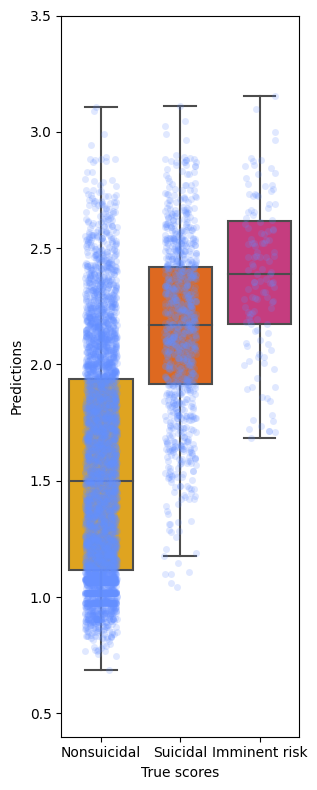

LGBMRegressor
LGBMRegressor


/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

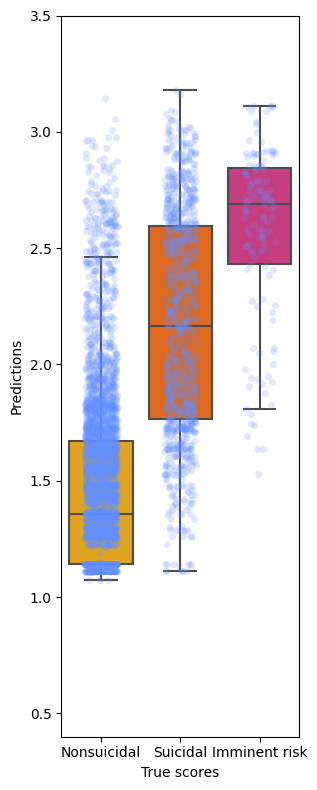

LGBMRegressor
LGBMRegressor


/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

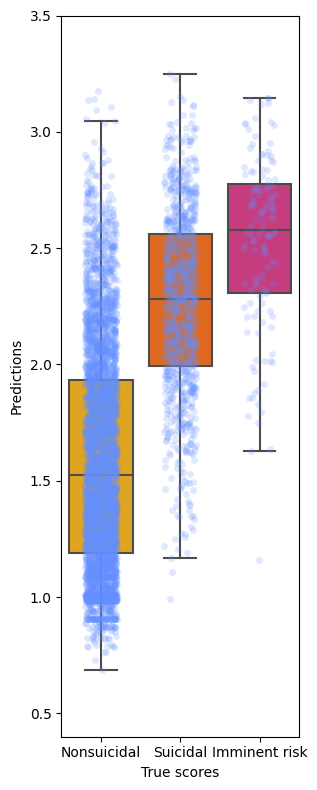

In [155]:
import seaborn as sns



feature_vectors = ['liwc22_semantic', 'srl_unvalidated','all-MiniLM-L6-v2']
timestamp = '24-02-16T06-25-10'

model_name = 'LGBMRegressor'

toy = False

for plot_type in ['strip']:

	for feature_vector in feature_vectors:	
		print(model)
		results_df = []
		
		results_dir = f'results_{timestamp}_{n}_regression_{balance_values[-1]}/'
		
		files = os.listdir('./data/output/ml_performance/'+results_dir)
		

		print(model)
		file = [n for n in files if  f"y_pred_{feature_vector}_{model_name}" in n and 'csv' in n]
		if file != []:
			if len(file)==1:	
				y_pred = pd.read_csv('./data/output/ml_performance/'+results_dir+file[0])




		if feature_vector == 'liwc22_semantic':
			y_test = dfs['test']['liwc22_y']
		else:
			X_train, y_train, X_test, y_test = get_splits(feature_vector)


		y_df = y_pred.copy()
		i = 2
		y_df['y_test'] = y_test
		y_df.columns = ['Predictions', 'True scores']

		if toy:
			y_df = y_df.sample(frac=0.20)


		# colorblind friendly https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000
			
		

			
		colors_severity = {
			
			1: '#FFB000',
			2: '#FE6100',
			3: '#DC267F',
			# 1: '#FFBB78',
			# 2: '#FF7F0E',
			# 3: '#D62728' 
			
		}

		# Create a boxplot with the specified color palette
		
		toy
		figsize = (3.25,8)
		plt.figure(figsize=figsize)  # Width=10 inches, Height=6 inches
		# sns.scatterplot(data = y_df, y = 'y_pred',x = 'y_test', alpha = 0.1)


		sns.boxplot(y='Predictions', x='True scores', data=y_df, palette=colors_severity, showfliers=False,
			  boxprops=dict(alpha=1))

		if plot_type == 'swarm':
			sns.swarmplot(y='Predictions', x='True scores', data=y_df,  color='0.25', alpha=0.3)
		elif plot_type == 'strip':
			sns.stripplot(y='Predictions', x='True scores', data=y_df,  color='#648FFF', alpha=0.2,jitter=0.2)

		plt.xticks(ticks = [0,1,2],labels = ['Nonsuicidal', 'Suicidal', 'Imminent risk'])
		plt.ylim((0.4,3.5))


		# Show the plot
		
		plt.tight_layout()
		plt.savefig(f'./data/output/figures/{plot_type}_boxplot_{feature_vector}_{model_name}.png', bbox_inches='tight', dpi=300)
		plt.show()


		

In [79]:
feature_vector

'liwc22_semantic'

# Feature importance plot

In [63]:
import pickle
with open(f'./data/input/ctl/ctl_dfs_features_{task}.pkl', 'rb') as f:
	dfs = pickle.load(f)


In [169]:
model = 'LGBMRegressor'
n = 'all'


results_dir = f'./data/output/ml_performance/results_{timestamp}_{n}_regression_{balance_values[-1]}/'

files = os.listdir(results_dir)
feature_vectors = ['srl_unvalidated', 'liwc22_semantic']
table_names = ['SRL GPT-4 + manual', 'LIWC-22 semantic']

rank_col_name = 'Rank'
files
feature_importance = []
for file, table_name in zip(feature_vectors, table_names):
    file1 = [n for n in files if ('feature_importance_'+file in n and 'clean' not in n)][0]
    
print(file1)
fi = pd.read_csv(results_dir+file1)
# fi.columns = ['Feature', 'Split', 'Gain']
# fi=fi.drop('Split', axis=1).round(1)
# fi = fi.reset_index()
# fi.columns = [rank_col_name, 'Feature', 'Gain']
# fi[rank_col_name]+=1
# fi[rank_col_name] = fi[rank_col_name].astype(str)
fi

feature_importance_liwc22_semantic_LGBMRegressor_gridsearch-True_all_24-02-16T06-25-10.csv


,feature,split,gain
0,death,63,4562.336212
1,Physical,56,1892.459318
2,allnone,69,955.012613
3,assent,97,825.110684
4,Conversation,54,512.583942
...,...,...,...
80,politic,6,8.559309
81,nonflu,4,4.421937
82,memory,2,3.406420
83,reward,2,1.866523


In [170]:
# For each feature, correlate feature with y
from scipy.stats import spearmanr
import math
liwc22_X = dfs['train']['liwc22_X']
liwc22_y = dfs['train']['liwc22_y']
liwc_rho = {}
for feature in liwc22_X.columns:
	filtered_list1, filtered_list2 = zip(*[(x, y) for x, y in zip(liwc22_y, liwc22_X[feature].values) if not math.isnan(x) and not math.isnan(y)])

	# Converting the tuples back to lists
	filtered_list1 = list(filtered_list1)
	filtered_list2 = list(filtered_list2)
	r,p = spearmanr(filtered_list1, filtered_list2)
	# r,p = spearmanr(liwc22_y, liwc22_X[feature])
	# if p <= 0.05:
	liwc_rho[feature] = np.round(r,2)
	if str(r)=='nan':
		
		print(feature)
	# else:
		# liwc_rho[feature] = np.nan


# For each feature, correlate feature with y
srl_unv_X = dfs['train']['srl_unvalidated']
srl_unv_y = dfs['train']['y']
srl_unv_rho = {}
for feature in srl_unv_X.columns:
	# remove nans:
	filtered_list1, filtered_list2 = zip(*[(x, y) for x, y in zip(srl_unv_y, srl_unv_X[feature].values) if not math.isnan(x) and not math.isnan(y)])

	# Converting the tuples back to lists
	filtered_list1 = list(filtered_list1)
	filtered_list2 = list(filtered_list2)
	r,p = spearmanr(filtered_list1, filtered_list2)
	# if p <= 0.05:
	srl_unv_rho[feature] = np.round(r,2)
	# else:
		# srl_unv_rho[feature] = np.nan
	




In [171]:
results_dir

'./data/output/ml_performance/results_24-02-16T06-25-10_all_regression_3/'

In [173]:
model = 'LGBMRegressor'
files = os.listdir(results_dir)
feature_vectors = ['srl_unvalidated', 'liwc22_semantic']
table_names = ['SRL unvalidated', 'LIWC-22 semantic']

rank_col_name = 'Rank'
files
feature_importance = []
for file, table_name in zip(feature_vectors, table_names):
	# timestamp_i = timestamp.replace('results_', '')
	# if file == 'liwc22_semantic':
	# 	file1 = f'feature_importance_{file}_{model}_gridsearch-True_all_24-02-16T00-03-59.csv'
	# else:
	file1 = f'feature_importance_{file}_{model}_gridsearch-True_all_{timestamp}.csv'
	
	
	
	fi = pd.read_csv(results_dir+file1)
	fi.columns = ['Feature', 'Split', 'Gain']
	fi=fi.drop('Split', axis=1).round(1)
	fi = fi.reset_index()
	fi.columns = [rank_col_name, 'Feature', 'Gain']
	fi[rank_col_name]+=1
	fi[rank_col_name] = fi[rank_col_name].astype(str)
	if 'liwc22' in file:
		fi['rho'] = fi['Feature'].map(liwc_rho)
	else:
		fi['rho'] = fi['Feature'].map(srl_unv_rho)

	fi.to_csv(results_dir+'feature_importance_'+file+'_clean.csv', index=False)
	columns = pd.MultiIndex.from_tuples([
	(table_name, rank_col_name),
	(table_name, 'Feature'),
	(table_name, 'Gain'),
	(table_name, 'rho'),
	])
	fi.columns = columns
	feature_importance.append(fi)

feature_importance_df = pd.concat([feature_importance[0],feature_importance[1].drop(columns=(table_names[1], rank_col_name))],axis=1)



feature_vectors = '_'.join(feature_vectors)



feature_importance_df.to_csv(results_dir+f'feature_importance_{feature_vectors}_gridsearch-True_all_{timestamp}_all.csv', index= 0 )
feature_importance_df.to_csv('./data/output/tables/'+f'feature_importance_{feature_vectors}_gridsearch-True_all_{timestamp}_all.csv', index= 0 )

display(feature_importance_df)

feature_importance_df.iloc[:20].to_csv(results_dir+f'feature_importance_{feature_vectors}_gridsearch-True_all_{timestamp}_top20.csv', index= 0 )

# top 15 and bottom 10
df0 = feature_importance[0].copy()
top_15 = df0.head(15)
bottom_10 = df0.tail(10)
empty_row = pd.DataFrame(np.nan, index=[0], columns=bottom_10.columns)
bottom_10 = pd.concat([empty_row, bottom_10]).reset_index(drop=True)
df0 = pd.concat([top_15, bottom_10])
df0 = df0.reset_index(drop=True)

df1 = feature_importance[1].copy()
top_15 = df1.head(15)
bottom_10 = df1.tail(10)
empty_row = pd.DataFrame(np.nan, index=[0], columns=bottom_10.columns)
bottom_10 = pd.concat([empty_row, bottom_10]).reset_index(drop=True)
df1 = pd.concat([top_15, bottom_10])
df1 = df1.reset_index(drop=True)


feature_importance_df = pd.concat([df0,df1],axis=1)
feature_importance_df.to_csv('./data/output/tables/'+f'feature_importance_{feature_vectors}_gridsearch-True_all_{timestamp}_top_and_bottom.csv', index= 0 )
display(feature_importance_df)



SRL unvalidated                                                        \
              Rank                                       Feature    Gain   
0                1  Active suicidal ideation & suicidal planning  3022.6   
1                2                      Lethal means for suicide  3006.1   
2                3                       Other suicidal language  2246.8   
3                4                            Direct self-injury   869.3   
4                5                           Other substance use   623.8   
..             ...                                           ...     ...   
80             NaN                                           NaN     NaN   
81             NaN                                           NaN     NaN   
82             NaN                                           NaN     NaN   
83             NaN                                           NaN     NaN   
84             NaN                                           NaN     NaN   

         LIWC-22 semantic                
     rho          Feature    Gain   rho  
0   0.50            death  4562.3  0.52  
1   0.58         Physical  1892.5  0.38  
2   0.47          allnone   955.0  0.41  
3   0.30           assent   825.1  0.38  
4   0.37     Conversation   512.6  0.31  
..   ...              ...     ...   ...  
80   NaN          politic     8.6 -0.01  
81   NaN           nonflu     4.4  0.12  
82   NaN           memory     3.4  0.07  
83   NaN           reward     1.9  0.05  
84   NaN        ethnicity     0.0 -0.00  

[85 rows x 7 columns]

SRL unvalidated                                                        \
              Rank                                       Feature    Gain   
0                1  Active suicidal ideation & suicidal planning  3022.6   
1                2                      Lethal means for suicide  3006.1   
2                3                       Other suicidal language  2246.8   
3                4                            Direct self-injury   869.3   
4                5                           Other substance use   623.8   
5                6                       Relationships & kinship   470.6   
6                7                               Fatigue & tired   340.2   
7                8                     Physical abuse & violence   264.0   
8                9                     Passive suicidal ideation   243.2   
9               10                                 Trauma & PTSD   209.8   
10              11                    Emotional pain & psychache   199.0   
11              12               Borderline Personality Disorder   197.9   
12              13                                Depressed mood   181.0   
13              14                               Hospitalization   146.2   
14              15                                       Anxiety   140.5   
15             NaN                                           NaN     NaN   
16              41                         Barriers to treatment    24.5   
17              42                      Gender & sexual identity    20.8   
18              43               Defeat & feeling like a failure    18.1   
19              44                                Burdensomeness    17.1   
20              45                                     Emptiness    16.2   
21              46                                Discrimination    14.5   
22              47                                 Perfectionism    13.2   
23              48                     Psychosis & schizophrenia     8.7   
24              49                        Poverty & homelessness     7.6   
25              50                             Social withdrawal     4.6   

         LIWC-22 semantic                              
     rho             Rank       Feature    Gain   rho  
0   0.50                1         death  4562.3  0.52  
1   0.58                2      Physical  1892.5  0.38  
2   0.47                3       allnone   955.0  0.41  
3   0.30                4        assent   825.1  0.38  
4   0.37                5  Conversation   512.6  0.31  
5   0.20                6   focusfuture   325.0  0.41  
6   0.26                7          want   312.1  0.35  
7   0.23                8       emo_anx   269.4  0.06  
8   0.27                9    substances   261.2  0.27  
9   0.02               10     Authentic   258.1  0.05  
10  0.21               11       illness   230.3  0.34  
11  0.18               12         Clout   221.8 -0.23  
12  0.10               13        Affect   205.6 -0.14  
13  0.20               14       cogproc   180.5  0.11  
14  0.07               15        Social   179.1 -0.11  
15   NaN              NaN           NaN     NaN   NaN  
16  0.03               76          risk    25.1  0.18  
17  0.06               77         moral    23.7  0.14  
18  0.14               78         money    16.3  0.09  
19  0.11               79        sexual    13.9  0.08  
20  0.08               80        filler    11.5  0.13  
21 -0.01               81       politic     8.6 -0.01  
22  0.06               82        nonflu     4.4  0.12  
23  0.04               83        memory     3.4  0.07  
24  0.06               84        reward     1.9  0.05  
25  0.03               85     ethnicity     0.0 -0.00

# Error analysis


In [ ]:
ts_i = '24-02-15T20-17-48'
n = 'all'

output_dir_i = output_dir + f'results_{ts_i}_{n}_{task}_{balance_values[-1]}/'

results = []
# for gridsearch in [True]:

# for feature_vector in ['srl_unvalidated', 'all-MiniLM-L6-v2']:#['srl_unvalidated']:#, 'srl_unvalidated']:
for feature_vector in feature_vectors:#['srl_unvalidated']:#, 'srl_unvalidated']:
	if feature_vector == 'liwc22_semantic':
		X_train, y_train,X_val, y_val, X_test, y_test = get_splits('liwc22')
		X_train = X_train[liwc_semantic]
		X_val = X_val[liwc_semantic]
		X_test = X_test[liwc_semantic]

	else:
		X_train, y_train,X_val, y_val, X_test, y_test = get_splits(feature_vector)

	


	if toy:
		X_train['y'] = y_train
		X_train = X_train.sample(n = 100)
		y_train = X_train['y'].values
		X_train = X_train.drop('y', axis=1)

	elif n!='all':
		X_train['y'] = y_train
		X_train = X_train.sample(n = n, random_state=42)
		y_train = X_train['y'].values
		X_train = X_train.drop('y', axis=1)


	if task == 'classification':
		encoder = LabelEncoder()

		# Fit and transform the labels to integers
		y_train = encoder.fit_transform(y_train)
		y_test = encoder.transform(y_test)

	
	for model_name in model_names: 
		y_pred = pd.read_csv(output_dir_i+f'y_pred_{feature_vector}_{model_name}_gridsearch-{gridsearch}_{n}_{ts_i}.csv')
		break
	break


In [ ]:
from sklearn import metrics
y_df = y_pred.copy()
i = 2
y_df['y_test'] = y_test
y_df.columns = ['y_pred', 'y_test']
y_df_i = y_df[y_df['y_test']==i]
y_df_i['error'] = y_df_i['y_pred'] - y_df_i['y_test']
y_df_i = y_df_i.sort_values(by='error')
X_test_text = dfs['test']['df_text']
print(X_test_text.shape, y_df.shape)
# display(X_test_text.head(), y_df[:5])
display(y_df_i.iloc[:10])
display(X_test_text.loc[y_df_i.index[:10]])
docs = X_test_text.loc[y_df_i.index[:10]]['text'].to_list()

print(docs)
# metrics.mean_absolute_error(y_test, y_pred.values)


(5370, 56) (5370, 2)


/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_29049/1097932210.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df_i['error'] = y_df_i['y_pred'] - y_df_i['y_test']


,y_pred,y_test,error
498,1.002305,2,-0.997695
3365,1.026596,2,-0.973404
4615,1.029347,2,-0.970653
1349,1.034901,2,-0.965099
1602,1.053014,2,-0.946986
3816,1.081325,2,-0.918675
2884,1.082255,2,-0.917745
1268,1.093415,2,-0.906585
2249,1.093415,2,-0.906585
2130,1.093415,2,-0.906585


,conversation_id,text,y,Passive suicidal ideation,Physical abuse & violence,Sexual abuse & harassment,Social withdrawal,Defeat & feeling like a failure,Burdensomeness,"Shame, self-disgust, & worthlessness",Guilt,Emotional pain & psychache,Panic,Grief & bereavement,Emptiness,Alcohol use,Other substance use,Impulsivity,Aggression & irritability,Anhedonia & uninterested,Rumination,Anxiety,Trauma & PTSD,Entrapment & desire to escape,Hopelessness,Perfectionism,Physical health issues & disability,Agitation,Fatigue & tired,Sleep issues,Discrimination,Barriers to treatment,Bullying,Suicide exposure,Finances & work stress,Gender & sexual identity,Lethal means for suicide,Psychosis & schizophrenia,Borderline Personality Disorder,Eating disorders,Depressed mood,Loneliness & isolation,Poverty & homelessness,Bipolar Disorder,Mental health treatment,Incarceration,Other suicidal language,Active suicidal ideation & suicidal planning,Direct self-injury,Direct self-injury 2,Relationship issues,Relationship issues 2,Existential meaninglessness & purposelessness,Relationships & kinship,Hospitalization,word_count
498,1142543,I can't take it anymore. I don't want to live ...,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,50
3365,3587200,Hi\n. I have anxiety attacks. Yea. Is because ...,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,6,4,1,1,0,0,2,0,0,0,0,0,0,0,2,0,0,6,0,0,6,0,0,0,0,0,0,0,0,8,1,0,0,0,338
4615,7335782,Hello. I’m just going through a really hard ti...,2,0,2,0,0,0,1,1,2,0,6,0,0,0,0,0,0,0,2,19,4,0,0,1,2,7,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2,0,9,0,546
1349,1848682,Yes. Hello?? Hello? I need help. I wanna die. ...,2,0,0,0,0,0,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2,0,0,2,0,40
1602,2062943,I need help. I don't really feel like living. ...,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10
3816,3944716,Hi. Ok. Ok. I am trying to hang on to a small ...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,0,160
2884,3152484,"STAY. stressed. hello [scrubbed] nice name , i...",2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,3,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,1,0,2,1,0,1,0,0,0,0,0,0,1,0,0,2,0,66
1268,1774112,Go. -- UNREADABLE MESSAGE --. -- UNREADABLE ME...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26
2249,2601437,Hello. I'm ready to die. Okay. STOP.,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
2130,2514130,Home. I want to kill my self. I'm safe. I'm bo...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,9


["I can't take it anymore. I don't want to live anymore. What is the point. I don't want to talk to a dude. You have no clue what postpartum depression feels like. I'm not saying you're not trained, would be nice to talk to someone who might have been through what I'm going through. Ok. Stop.", "Hi\n. I have anxiety attacks. Yea. Is because since I started 7th [scrubbed] I been getting a lot of anxiety attacks I been getting a lot of stress. Math I did my first test on Friday and I'm going to get my results tomorrow and I'm nervous that I'm going to get a low [scrubbed]. But there's something else that. gives me Anxiety attacks. Well I dated this boy as we dated for 1 month and 2 weeks but because of my anxiety attacks I broke up with him but i didn't know what I was doing so I broke up. with him and tbh I regret breaking up with him cuz fr loved him so much and I still love him but after 2 days i broke up with him he got a new [scrubbed] and tbh. feel really jealous because he told me

In [ ]:
import dill
sys.path.append( './../../concept-tracker/') # TODO: replace with pip install construct-tracker
from concept_tracker import lexicon


def load_lexicon(path):
	lexicon = dill.load(open(path, "rb"))
	return lexicon
srl = load_lexicon("./data/input/lexicons/suicide_risk_lexicon_calibrated_unmatched_tokens_unvalidated_24-02-15T19-30-52.pickle")


feature_vectors, matches_counter_d, matches_per_doc, matches_per_construct  = lexicon.extract(docs,
																						srl.constructs,normalize = normalize_lexicon, return_matches=True,
																						add_lemmatized_lexicon=True, lemmatize_docs=False,
																						exact_match_n = srl.exact_match_n,exact_match_tokens = srl.exact_match_tokens)

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:00<00:00, 297.34it/s]


In [ ]:
i = 2
print(docs[i])
constructs_alphabetical = constructs_in_order.copy()
constructs_alphabetical.sort()
pd.DataFrame(matches_per_doc[i])[constructs_alphabetical]

Hello. I’m just going through a really hard time. Ok. It’s just been hard I lost my grandma not to long ago then my cousin I have these panic attacks slit my mind just keeps racing and worrying about the future. It’s like I’m scared of everything I’m 15 I shouldn’t feel like this and I don’t know what to do. It’s just I’m always so anxious about what’s going to happen my dad is my only parent I have and my two siblings we have never had our own home we have always bounced from family’s houses I’m scared I’m gonna end up like that and then I think about my dad passing away I don’t know how to control it or stop these thoughts and I’m scared I’m always gonna be like this. Ya I am I’m scared to grow up and stuff. Ya I have people around me who help but they can only do so much and I don’t know how to do it on my own I’m scared I’m gonna blink my eyes and they are gonna all be gone. Ya. It is bcs my grandma basically raised me she was my [scrubbed] ever since she passed I feel like I’m flo

,Active suicidal ideation & suicidal planning,Aggression & irritability,Agitation,Alcohol use,Anhedonia & uninterested,Anxiety,Barriers to treatment,Bipolar Disorder,Borderline Personality Disorder,Bullying,Burdensomeness,Defeat & feeling like a failure,Depressed mood,Direct self-injury,Discrimination,Eating disorders,Emotional pain & psychache,Emptiness,Entrapment & desire to escape,Existential meaninglessness & purposelessness,Fatigue & tired,Finances & work stress,Gender & sexual identity,Grief & bereavement,Guilt,Hopelessness,Hospitalization,Impulsivity,Incarceration,Lethal means for suicide,Loneliness & isolation,Mental health treatment,Other substance use,Other suicidal language,Panic,Passive suicidal ideation,Perfectionism,Physical abuse & violence,Physical health issues & disability,Poverty & homelessness,Psychosis & schizophrenia,Relationship issues,Relationships & kinship,Rumination,Sexual abuse & harassment,"Shame, self-disgust, & worthlessness",Sleep issues,Social withdrawal,Suicide exposure,Trauma & PTSD
0,0,0,7,0,0,19,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,6,0,1,2,2,0,0,0,9,2,0,1,0,0,0,4
1,[],[],"[anxious, bother, panic, worry]",[],[],"[anxiety, anxious, bother, overthinking, panic...",[],[depress],[],[],[bother],[],[depress],[],[],[],[],[],[],[],[],"[job, work]",[],[],"[regret, sorry]",[],[],[],[],[],[],[],[],[],"[panic, panic attack, worry]",[],[overthinking],[control i],[panic attack],[],[],[],"[cousin, dad, family, grandma, parent]","[overthinking, worry]",[],[regret],[],[],[],"[anxiety, panic attack]"
